In [1]:
# https://www.kaggle.com/neurol/keras-classifier
# https://www.kaggle.com/shawon10/captcha-recognition
# https://www.kaggle.com/dhruvaditya/captcha-recognition

# Objetivo

Criar um sistema capaz de decifrar imagend de Captcha

In [309]:
#Imports
from pathlib import Path
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, ReLU
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
#from tensorflow.keras.layers.advanced_activations import LeakyReLU
#from tensorflow.keras.layers.convolutional import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import callbacks
import os
import cv2
import string
import numpy as np
import matplotlib.pyplot as plt

# Imagens

Exemplo de imagens. Os caracteres presentes na imagem estão descritos no nome da imagem, o captcha é composto por letras e números.

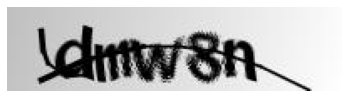

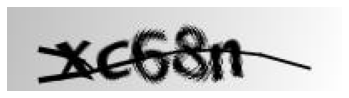

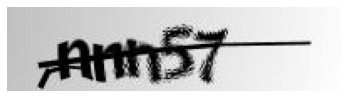

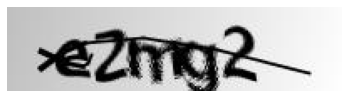

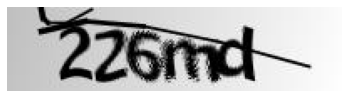

In [20]:
fig = plt.figure()
img=cv2.imread('images/samples/dmw8n.png')
plt.imshow(img)
plt.axis('off')

fig = plt.figure()
img=cv2.imread('images/samples/xc68n.png')
plt.imshow(img)
plt.axis('off')

fig = plt.figure()
img=cv2.imread('images/samples/nnn57.png')
plt.imshow(img)
plt.axis('off')

fig = plt.figure()
img=cv2.imread('images/samples/e2mg2.png')
plt.imshow(img)
plt.axis('off')

fig = plt.figure()
img=cv2.imread('images/samples/226md.png')
plt.imshow(img)
plt.axis('off')

plt.show()

In [183]:
symbols = string.ascii_lowercase + "0123456789"
num_symbols = len(symbols)
img_shape = (50, 200, 1)
input_dim = 1

In [108]:
len(symbols)

36

In [184]:
def preprocess(x):
    return (x/255)*2-1

def deprocess(x):
    return np.uint8((x+1)/2*255) 

In [201]:
###
#
# Preprocessamento dos Dados
#
###

def preprocess_data(workplace='./images/samples'):
    imgs_folder = [i for i in Path(workplace).iterdir()]
    n_samples = len(imgs_folder)
    X = np.zeros((n_samples, 50, 200, 1))
    y = np.zeros((5, n_samples, num_symbols))

    for i, path in enumerate(imgs_folder):
        
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        pic_target = path.stem # retira o .png
            
        # Coloca o valor dos pixels entre 0 e 1
        img = preprocess(img)
        # Utiliza apenas o canal vermelho
        img = np.reshape(img, (50, 200, 1))
        # cada captcha possui 5 caracteres
        targs = np.zeros((5, num_symbols))

        # Faz one hot encode
        for j, letra in enumerate(pic_target):
            ind = symbols.find(letra)
            targs[j, ind] = 1

        X[i] = img
        y[:, i] = targs

    return X, y

In [318]:

def create_net(g_learning_rate=0.1,g_beta_1=0.1):
    # 50 200 1
    img = layers.Input(shape=img_shape)
    c1 = layers.Conv2D(48, kernel_size=5, strides=1, padding='same',name="c1")(img) # 25 100 48 
    p1  = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid',name="p1")(c1)
    c2 = layers.Conv2D(48, kernel_size=5, strides=1, padding='same',name="c2")(p1) # 25 100 48 
    p2 = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid',name="p2")(c2) # 12 50 48
    c3 = layers.Conv2D(64, kernel_size=5, strides=1, padding='same',name="c3")(p2) # 25 100 64
    p3 = layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid',name="p3")(c3) # 6 25 64
    flatten = layers.Flatten(name="flatten")(p3)
    outs = []
    l1 = layers.Dense(512, activation='relu')(flatten)
    for _ in range(5):
        res = layers.Dense(36, activation='softmax')(l1)
        outs.append(res)
    model = Model(img, outs)
    #opt = optimizers.SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss=['categorical_crossentropy', 'categorical_crossentropy',
                                   'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'])
    #model.compile(optimizer=Adam(lr=g_learning_rate, beta_1=g_beta_1), loss=['categorical_crossentropy', 'categorical_crossentropy',
    #                               'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy'])
    model.summary()
    return model


In [319]:
def predict(filepath):
    
    img = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE) / 255.
    res = np.array(net.predict(img[np.newaxis, :, :, np.newaxis]))
    ans = np.reshape(res, (5, 36))
    l_ind = []
    probs = []
    
    for a in ans:
        l_ind.append(np.argmax(a))
        probs.append(np.max(a))

    capt = ''
    for l in l_ind:
        capt += symbols[l]
    return capt, sum(probs) / 5

In [320]:
X, y = preprocess_data()
len(y)

5

In [321]:


X, y = preprocess_data()
X_train, y_train = X[:970], y[:, :970]
X_test, y_test = X[970:], y[:, 970:]

net = create_net()
history = net.fit(X_train, [y_train[0], y_train[1], y_train[2], y_train[3], y_train[4]], batch_size=32, epochs=300, validation_split=0.2)

net.evaluate(X_test, [y_test[0], y_test[1], y_test[2], y_test[3], y_test[4]])

# Acertos e erros de teste:



Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 50, 200, 1)] 0                                            
__________________________________________________________________________________________________
c1 (Conv2D)                     (None, 50, 200, 48)  1248        input_21[0][0]                   
__________________________________________________________________________________________________
p1 (MaxPooling2D)               (None, 25, 100, 48)  0           c1[0][0]                         
__________________________________________________________________________________________________
c2 (Conv2D)                     (None, 25, 100, 48)  57648       p1[0][0]                         
___________________________________________________________________________________________

[42.59708709716797, 34.328606, 1.5826197, 2.9303045, 2.839668, 2.0898416]

In [322]:

print('8n5p3', predict('images/samples/8n5p3.png'))
print('f2m8n', predict('images/samples/f2m8n.png'))
print('dce8y', predict('images/samples/dce8y.png'))
print('3eny7', predict('images/samples/3eny7.png'))
print('npxb7', predict('images/samples/npxb7.png'))

8n5p3 ('7n5y3', 0.82472904920578)
f2m8n ('f2myn', 0.7483933925628662)
dce8y ('dce8y', 0.886176347732544)
3eny7 ('3eny7', 0.9317207932472229)
npxb7 ('5pcy3', 0.6725895404815674)
